# Introduction to Research Module

This tutorial introduces Research functionality of batchflow.

Research class allows easily experimenting with models parameters and entire test and train workflow configurations as well as saving and loading results of experiments in a unified form.

## Basic example

### Imports and Utilities

We start with some useful imports and constant definitions

In [1]:
import os
import shutil

import sys
sys.path.append('../../..')

from matplotlib import pyplot as plt
%matplotlib inline

from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16
from batchflow.research import Research, Option, Domain, Results

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
BATCH_SIZE=64
ITERATIONS=10

In [3]:
def clear_previous_results(res_name):
    if os.path.exists(res_name):
        shutil.rmtree(res_name)

### Single-experiment Research

We define a very simple pipeline that loads some MNIST data, and trains a VGG7 model on it. It also saves the loss on each iteration in a pipeline variable. Let's call it an experiment

#### Loading Data and Creating Pipeline

We call a lazy version of pipeline's `run` method to define batch size to use. We pass `n_epochs=None`, because the duration of our experiment will be controlled by Research

In [4]:
mnist = MNIST()

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

#### Creating Research

The simpliest thing we can do with Research is running this experiment several times to see how loss'es dynamics changes from run to run.

To do this we define a Research object and add the pipeline to it. We call `add_pipeline` method and pass the `train_ppl` as the first parameter. The `variables` parameter gets a string or a list of strings that indicate which pipeline variables will be monitored by Research and written to research results on each iteration. We also provide `name` that will be written to results to indicate from where actually these results come.

`logging=True` adds additional logging of the pipeline execution to log file

In [5]:
research = (Research()
            .init_domain(n_reps=4)
            .add_pipeline(train_ppl, variables='loss', name='train_ppl', logging=True))

#### Running Research 

Each research is assigned with a name and writes its results to a folder with this name. The names must be unique, so if one attempts to run a research with a name that already exists, an error will be thrown. In the cell below we clear the results of previous research runs so as to allow multiple runs of a research. This is done solely for purposes of ths tutorial and should not be done in real work

In [6]:
res_name='vgg7_research'
clear_previous_results(res_name)

Now we run this Research.

We call a Research object's `run` method and we pass following parameters:
* `n_iters` - how many iterations will the experiment consist of. Each iteration here consists of processing a single batch
* `n_reps` - how many times we run our experiment
* `bar` - to provide a tqdm progress bar

In [7]:
research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research vgg7_research is starting...


Domain updated: 0: : 0it [00:00, ?it/s]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  25%|██▌       | 10/40.0 [00:29<01:27,  2.90s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  50%|█████     | 20/40.0 [00:49<00:49,  2.46s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  75%|███████▌  | 30/40.0 [01:09<00:23,  2.33s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0: 100%|██████████| 40/40.0 [01:32<00:00,  2.31s/it]


#### Investigating Research Results

Each research is assigned with a `name` argument provided to `run`.
Results of the research and its log are saved in a folder with the same name in the working directory. 
When we check current directory content we can see *vgg_research* folder with results of the research done above

In [8]:
!ls -la

total 652
drwxr-xr-x 11 root root   4096 Oct 23 23:12 .
drwxr-xr-x  8 root root   4096 Oct 22 15:48 ..
drwxr-xr-x  2 root root   4096 Oct 22 15:48 .ipynb_checkpoints
-rw-r--r--  1 root root  35570 Oct 23 23:12 01_introduction_to_research.ipynb
-rw-r--r--  1 root root  91055 Sep  5 15:41 02_advanced_usage_of_research.ipynb
-rw-r--r--  1 root root 484641 Sep  5 15:41 03_plotting_research_results.ipynb
-rw-r--r--  1 root root   1007 Sep  5 15:41 README.md
drwxr-xr-x  5 root root   4096 Oct 23 20:43 fun_research
drwxr-xr-x  5 root root   4096 Oct 23 20:47 get_metrics_research
drwxr-xr-x  2 root root   4096 Sep  5 15:41 img
drwxr-xr-x  4 root root   4096 Oct 23 20:44 my_mdl
drwxr-xr-x  5 root root   4096 Oct 23 20:40 train_test_research
drwxr-xr-x  5 root root   4096 Oct 23 23:13 vgg7_research
drwxr-xr-x  5 root root   4096 Oct 23 22:40 vgg_layout_bias_poolstrides_research
drwxr-xr-x  4 root root   4096 Oct 23 20:20 vgg_layout_bias_poolstrides_research_loaded


To see the experiments' results we call `load_result` method which returns a Pandas Dataframe. We can see that it has 4 collumns which contain 
* repetition - The number of experiment run
* iteration - the number of iteration
* name - the source of the variable
* loss - this is the variable name that we provided to `add_pipeline`

In [9]:
results = research.load_results()
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
iteration       40 non-null int64
loss            40 non-null float64
name            40 non-null object
repetition      40 non-null int64
sample_index    40 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.6+ KB


In [10]:
results.sample(10)

,iteration,loss,name,repetition,sample_index
10,0,2.898466,train_ppl,0,0
8,8,1.026098,train_ppl,1,0
11,1,2.059894,train_ppl,0,0
5,5,1.323031,train_ppl,1,0
0,0,2.791783,train_ppl,1,0
12,2,1.888752,train_ppl,0,0
33,3,1.797547,train_ppl,2,0
4,4,1.764108,train_ppl,1,0
14,4,1.569553,train_ppl,0,0
21,1,2.264289,train_ppl,3,0


We can now draw a nice plot showing our loss dynamics on each experiment repetition

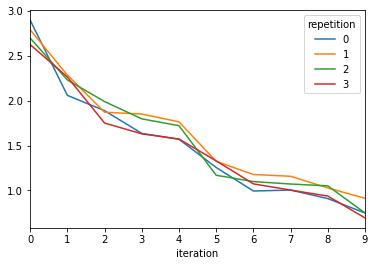

In [11]:
results.pivot(index='iteration', columns='repetition', values='loss').plot()

## Introducing grids

We have learned to run multiple repetitions of a single experiment with Research. 

We can also run several experiments with different parameters in one research. Suppose we want to compare the performance of VGG7 and VGG16 models with different layouts ('convolution-normalization-activation' vs 'convolution-activation-normalization') with default bias and pool_strides settings (which are no bias and 2) and we would also like to compare VGG7 with pool_stride 1 and VGG16 with pool_stride 2, both with bias and default 'cna' layout.

#### Defining Grids

We define a grid of parameters as follows. 
We define an Option that consists of the parameter to vary and a list of values that we want to try in our research. Each parameter value defines a node in a parameter grid. We can add grids to unite the nodes, multiply grids to get Cartesian product and multiply options node-wise with `Option.product()`.

`grid.gen_configs()` returns a generator that yields one node (that is, a single experiment specification) at a time. Printing a list of all nodes shows us all experiment modifications in a dict-like mode.

In [12]:
domain = (Option('layout', ['cna', 'can']) * Option('model', [VGG7, VGG16]) * Option('bias', [False]) * Option('stride', [2])
        +  Option('layout', ['cna']) * Option('bias', [True]) * (Option('model', [VGG7, VGG16]) @ Option('stride', [1, 2])))
list(domain.iterator)

[ConfigAlias({'layout': 'cna', 'stride': '2', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'stride': '2', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'stride': '2', 'model': 'VGG7', 'bias': 'False'}),
 ConfigAlias({'layout': 'can', 'stride': '2', 'model': 'VGG16', 'bias': 'False'}),
 ConfigAlias({'layout': 'cna', 'stride': '1', 'model': 'VGG7', 'bias': 'True'}),
 ConfigAlias({'layout': 'cna', 'stride': '2', 'model': 'VGG16', 'bias': 'True'})]

#### Creating Pipelines With Variable Parameters

We should now update `model_config` so that it could read the values from the grid.

We pass named expressions as parameters values with names from our parameter grid. 
We define layout, pool_strides and bias in the model config and we pass model type as a named expression to `init_model` method of the pipeline (config option named expression `C()` should be used)

In [13]:
model_config.update({
    'body/block/layout': C('layout'),
    'body/block/pool_strides': C('stride'),
    'common/conv/use_bias': C('bias'),
})

# For reference: previous train_template definition 
#     train_template = (Pipeline()
#                 .init_variable('loss', init_on_each_run=list)
#                 .init_model('dynamic', VGG7, 'conv', config=model_config) # Note model class defined explicitly
#                 .to_array()
#                 .train_model('conv', 
#                              images=B('images'), labels=B('labels'),
#                              fetches='loss', save_to=V('loss', mode='w'))
#     )

train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_model('dynamic', C('model'), 'conv', config=model_config) # Model class defined via named expression
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

#### Adding Grid To Research

We define a new research as before but also add the grid of parameters with `add_grid` method. After that we run the research, and it takes much longer because we are now running 6 different experiments 2 times each. 

In [14]:
res_name = 'vgg_layout_bias_poolstrides_research'
clear_previous_results(res_name)

research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train')
            .init_domain(domain, n_reps=2))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research vgg_layout_bias_poolstrides_research is starting...


Domain updated: 0: : 0it [00:00, ?it/s]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:   8%|▊         | 10/120.0 [00:29<05:28,  2.98s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  17%|█▋        | 20/120.0 [00:53<04:26,  2.66s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  25%|██▌       | 30/120.0 [01:12<03:38,  2.43s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  33%|███▎      | 40/120.0 [01:35<03:10,  2.38s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  42%|████▏     | 50/120.0 [01:55<02:42,  2.31s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  50%|█████     | 60/120.0 [02:20<02:20,  2.33s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  58%|█████▊    | 70/120.0 [02:40<01:54,  2.29s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  67%|██████▋   | 80/120.0 [03:03<01:31,  2.29s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  75%|███████▌  | 90/120.0 [03:23<01:07,  2.26s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  83%|████████▎ | 100/120.0 [03:45<00:45,  2.26s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  92%|█████████▏| 110/120.0 [04:06<00:22,  2.24s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0: 100%|██████████| 120/120.0 [04:30<00:00,  2.25s/it]


Research results now contain new columns *layout*, *stride*, *bias* and *model* with corresponding parameter values.

In [15]:
results = research.load_results()
results.head()

,bias,iteration,layout,loss,model,name,repetition,sample_index,stride
0,False,0,can,4.298482,VGG16,train,1,0,2
1,False,1,can,3.145742,VGG16,train,1,0,2
2,False,2,can,2.383410,VGG16,train,1,0,2
3,False,3,can,1.756505,VGG16,train,1,0,2
4,False,4,can,1.800853,VGG16,train,1,0,2


## Controlling *load_results* Output

#### Loading Results With Single-column Config Representation

To combine different config options in a single-column string representation we can pass `concat_config=True` to `load_results` method.

In [16]:
results = research.load_results(concat_config=True)
results.head()

,config,iteration,loss,name,repetition,sample_index
0,bias_False-layout_can-model_VGG16-stride_2,0,4.298482,train,1,0
1,bias_False-layout_can-model_VGG16-stride_2,1,3.145742,train,1,0
2,bias_False-layout_can-model_VGG16-stride_2,2,2.383410,train,1,0
3,bias_False-layout_can-model_VGG16-stride_2,3,1.756505,train,1,0
4,bias_False-layout_can-model_VGG16-stride_2,4,1.800853,train,1,0


This is very useful when comparing separate experiments  

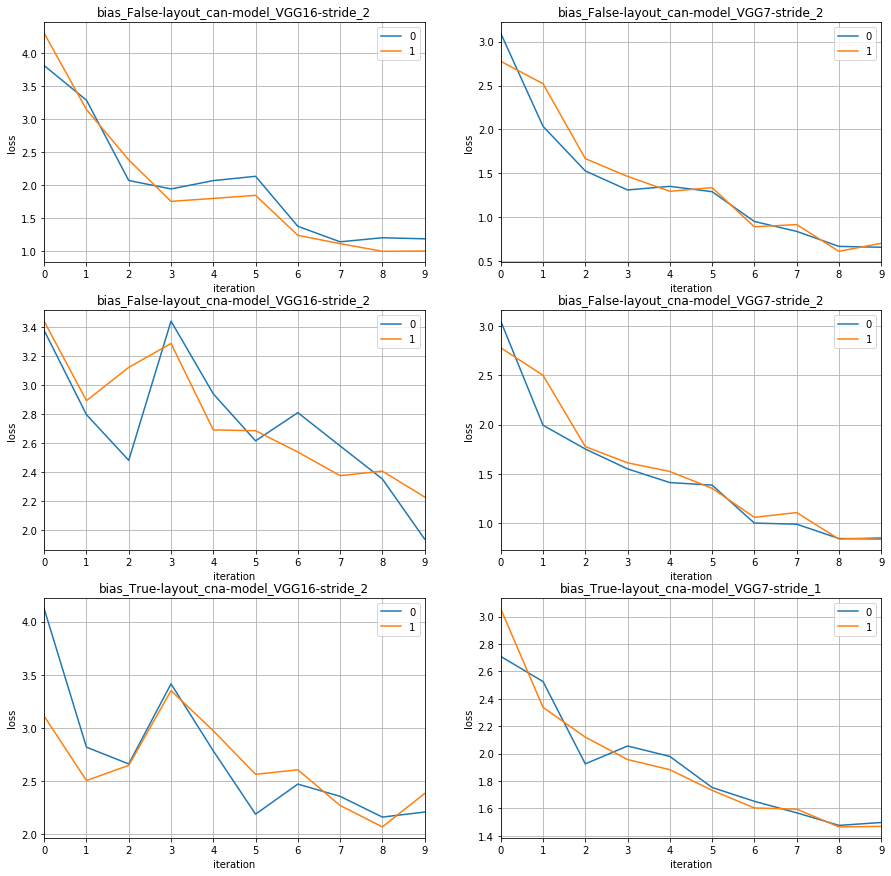

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, (config, df) in enumerate(results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='repetition', values='loss').plot(ax=ax[x, y])
    ax[x, y].set_title(config)
    ax[x, y].set_xlabel('iteration')
    ax[x, y].set_ylabel('loss')
    ax[x, y].grid(True)
    ax[x, y].legend()

#### Loading Results With Filters

We can filter the results to use certain parameter values.

In [19]:
research.load_results(aliases={'model': 'VGG7'}).head()

,bias,iteration,layout,loss,model,name,repetition,sample_index,stride
0,False,0,cna,3.051472,VGG7,train,0,0,2
1,False,1,cna,1.993346,VGG7,train,0,0,2
2,False,2,cna,1.751999,VGG7,train,0,0,2
3,False,3,cna,1.550168,VGG7,train,0,0,2
4,False,4,cna,1.410874,VGG7,train,0,0,2


The code below does effectively the same but when passing `config` we define actual parameter values (like model class), not their string representations

In [20]:
research.load_results(configs={'model': VGG7}).head()

,bias,iteration,layout,loss,model,name,repetition,sample_index,stride
0,False,0,cna,3.051472,VGG7,train,0,0,2
1,False,1,cna,1.993346,VGG7,train,0,0,2
2,False,2,cna,1.751999,VGG7,train,0,0,2
3,False,3,cna,1.550168,VGG7,train,0,0,2
4,False,4,cna,1.410874,VGG7,train,0,0,2


We can also get results corresponding to certain repetitions of experiments or certain iterations.

Here we have only one output variable - *loss* - but if we had many we could also load only some of them using `variables` parameter

In [23]:
# research.load_results(repetition=1, iterations=[0,9], variables=['loss']).head()

## Loading Saved Research

As mentioned above, after each run of a research a folder with log information and results is created
Now that 2 researches have run, we can see their resulting folders *vgg7_research* and *vgg_layout_bias_poolstrides_research*

In [24]:
!ls -la

total 716
drwxr-xr-x 11 root root   4096 Oct 23 23:18 .
drwxr-xr-x  8 root root   4096 Oct 22 15:48 ..
drwxr-xr-x  2 root root   4096 Oct 22 15:48 .ipynb_checkpoints
-rw-r--r--  1 root root  99772 Oct 23 23:18 01_introduction_to_research.ipynb
-rw-r--r--  1 root root  91055 Sep  5 15:41 02_advanced_usage_of_research.ipynb
-rw-r--r--  1 root root 484641 Sep  5 15:41 03_plotting_research_results.ipynb
-rw-r--r--  1 root root   1007 Sep  5 15:41 README.md
drwxr-xr-x  5 root root   4096 Oct 23 20:43 fun_research
drwxr-xr-x  5 root root   4096 Oct 23 20:47 get_metrics_research
drwxr-xr-x  2 root root   4096 Sep  5 15:41 img
drwxr-xr-x  4 root root   4096 Oct 23 20:44 my_mdl
drwxr-xr-x  5 root root   4096 Oct 23 20:40 train_test_research
drwxr-xr-x  5 root root   4096 Oct 23 23:13 vgg7_research
drwxr-xr-x  5 root root   4096 Oct 23 23:14 vgg_layout_bias_poolstrides_research
drwxr-xr-x  4 root root   4096 Oct 23 20:20 vgg_layout_bias_poolstrides_research_loaded


We can use `Research.load` class method to load a previousely run research using its name

In [25]:
loaded_research = Research.load('vgg_layout_bias_poolstrides_research')

We can check its parameters...

In [26]:
loaded_research.describe()

{'_update_config': None,
 '_update_domain': None,
 'bar': True,
 'branches': 1,
 'devices': [[{'device': 'None'}]],
 'domain': Domain([[Option(layout, ['cna', 'can']), Option(model, ['VGG7', 'VGG16']), Option(bias, ['False']), Option(stride, ['2'])], [Option(layout, ['cna']), Option(bias, ['True']), Option(model, ['VGG7']), Option(stride, ['1'])], [Option(layout, ['cna']), Option(bias, ['True']), Option(model, ['VGG16']), Option(stride, ['2'])]]),
 'executables': OrderedDict([('train',
                              <batchflow.research.executable.Executable object at 0x7f8d5a50d7b8>)]),
 'loaded': True,
 'n_configs': None,
 'n_iters': 10,
 'n_reps': 2,
 'name': 'vgg_layout_bias_poolstrides_research',
 'repeat_each': 100,
 'timeout': 5,
 'trials': 2,
 'worker_class': <class 'batchflow.research.workers.PipelineWorker'>,
 'workers': 1}


... and run it one more time

In [27]:
res_name = 'vgg_layout_bias_poolstrides_research_loaded'
clear_previous_results(res_name)

loaded_research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Starting loaded research. All parameters passed to run except name, bar and devices are ignored.
 If `devices` is not provided it will be inherited
Research vgg_layout_bias_poolstrides_research_loaded is starting...


Domain updated: 0: : 0it [00:00, ?it/s]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:   8%|▊         | 10/120.0 [00:30<05:34,  3.04s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  17%|█▋        | 20/120.0 [00:54<04:32,  2.72s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  25%|██▌       | 30/120.0 [01:14<03:43,  2.49s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  33%|███▎      | 40/120.0 [01:39<03:18,  2.48s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  42%|████▏     | 50/120.0 [02:00<02:48,  2.41s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  50%|█████     | 60/120.0 [02:24<02:24,  2.41s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  58%|█████▊    | 70/120.0 [02:44<01:57,  2.36s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  67%|██████▋   | 80/120.0 [03:10<01:35,  2.39s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  75%|███████▌  | 90/120.0 [03:32<01:10,  2.36s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  83%|████████▎ | 100/120.0 [03:55<00:47,  2.36s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  92%|█████████▏| 110/120.0 [04:18<00:23,  2.35s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0: 100%|██████████| 120/120.0 [04:42<00:00,  2.35s/it]


Note that `n_reps=4` from `run` arguments is ignored and the values from the loaded research are used

In [28]:
loaded_research.load_results().sample(10)

,bias,iteration,layout,loss,model,name,repetition,sample_index,stride
49,False,9,can,0.657980,VGG7,train,0,0,2
76,True,6,cna,2.447713,VGG16,train,0,0,2
104,False,4,can,1.180101,VGG7,train,1,0,2
37,True,7,cna,2.377224,VGG16,train,1,0,2
26,False,6,can,1.172716,VGG16,train,0,0,2
116,False,6,cna,2.183754,VGG16,train,1,0,2
36,True,6,cna,2.331794,VGG16,train,1,0,2
119,False,9,cna,2.517259,VGG16,train,1,0,2
88,False,8,cna,2.297315,VGG16,train,0,0,2
67,False,7,cna,1.049412,VGG7,train,1,0,2


## More Complex Execution Strategies

Usually we would like to run more than a single train pipeline.

Let's define a test pipeline to monitor a model's loss on test set while learning. 

#### Creating Train Pipeline

We start with defining a train pipeline as before

In [29]:
domain = Option('layout', ['cna', 'can'])

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

#### Creating Test Pipeline

We want the test pipeline to be run on the whole test set from time to time during training. 

In order to get this, we specify lazy-run in test pipeline with `n_epochs=1` and we pass `run=True` to research's `add_pipeline`. These 2 parameter values tell Research to run the pipeline on the whole test set for 1 epoch, instead of running it batch-wise (which is how the test pipeline is run). We will also pass `execute=100` parameter to `add_pipeline` to tell Research that this pipeline should be executed only on each 100-th iteration.

To let the test pipeline to use the model trained by train pipeline we pass this model via `C('import_from')` named expression. We will set its value when creating `Research`.

In [30]:
test_template = (Pipeline()
                 .init_variable('test_loss')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='loss', save_to=V('test_loss', mode='w'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1) #Note  n_epochs=1
                )

test_ppl = test_template << mnist.test

#### Creating Research with 2 Pipelines

As mentioned before, we pass `execute=100` parameter to `add_pipeline` to tell Research that this pipeline should be executed only on each 100-th iteration.

`execute` parameter defines frequency of pipeline execution. One can tell research to execute a pipeline periodically and pass an `int`, or to execute it on specific iteration by passing zero-based iteration number in following format: `'#{it_no}'` or by simply passing `'last'`. `execute` can also be a list, for example `execute=["#0', '#123', 100, 'last']` means that a pipeline will be executed on first iteration, 124-th iteration, every 100-th iteration and the last one.

In order to import model from train to test pipeline, we pass `import_from='train_ppl'` parameter to `add_pipeline`, where `'train_ppl'` is the name of our train pipeline.

In [31]:
from batchflow.research import Results
from batchflow.research import ResearchPipeline as RP
from batchflow.research import ResearchIteration as RI

TEST_EXECUTE_FREQ = 10

res_name = 'train_test_research'
clear_previous_results(res_name)

research = (Research()
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, variables='test_loss', name='test_ppl',
                        execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl')) # Note run=True
            .init_domain(domain))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research train_test_research is starting...


Domain updated: 0: : 0it [00:00, ?it/s]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  50%|█████     | 10/20.0 [00:38<00:38,  3.82s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0: 100%|██████████| 20/20.0 [01:04<00:00,  3.22s/it]


Now our research results contain entries for test_ppl

In [32]:
research.load_results(names='test_ppl').head()

,iteration,layout,name,sample_index,test_loss,train_loss
0,9,can,test_ppl,1,0.297093,NaN
1,9,cna,test_ppl,1,0.333670,NaN


## Functions

In order to perform some computations while running pipelines or to acquire values that are not produced by the model explicitely, one can use functions.

We will now add a function that saves model's snapshots on different stages of learning and reports the path of saved snapshot

#### Defining Functions To Be Executed By Reasearch

We define a function to be executed during experiment's iterations. Such functions take 2 required parameters: `iteration` and `experiment` which are fed to it by Research and optional keyword parameters which should be provided externally.

Here we declare additional parameters `pipeline` and `model_name` with the names of the model to save and the pipeline is it defined in. We also provide opional path parameter. Firstly, we construct target path using experiment descripton and iteration number. After that we get the pipeline needed by its name. Finally, we save the model with the name from parameters in this pipeline. Our function will return target path, so that one could easyly find the saved model

In [33]:
def save_model(iteration, unit, model_name, path='./'):
    """ Save model to a path."""
    path = os.path.join(path, unit.config.alias(as_string=True) + '_' + str(iteration))
    pipeline = unit.pipeline
    pipeline.save_model_now(model_name, path)
    return path

#### Adding Functions To Research

We define a new reseach. Note that we now don't ask the test pipeline to write any variables to results explicitely (we don't pass `variables` parameter to corresponding `add_pipeline`).

To add a function we call `add_function` method, providing it with a function object and`returns` parameters that specifies what should be written to research results.  We also pass keyword parameters `pipeline='train_ppl', model_name='conv', path='my_mdl'` that will be substituted to `save_model` function.

In [34]:
res_name = 'fun_research'
clear_previous_results(res_name)

from batchflow.research import ResearchExecutableUnit as EU

research = (Research()
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'))
            .add_callable(save_model, returns='snapshot_path', name='save_model_fn',
                          execute=TEST_EXECUTE_FREQ, iteration=RI(), unit=EU('train_ppl'), model_name='conv', path='my_mdl')
            .init_domain(domain, n_reps=1))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research fun_research is starting...


Domain updated: 0: : 0it [00:00, ?it/s]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  50%|█████     | 10/20.0 [00:38<00:38,  3.82s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0: 100%|██████████| 20/20.0 [01:03<00:00,  3.17s/it]


Research results now contain paths to models snapshots from `'save_model_fn'`

We can load results that come from a certain source by passing `names` parameter to `load_results`

In [35]:
research.load_results(names='save_model_fn').head()

,iteration,layout,name,sample_index,snapshot_path,train_loss
0,9,can,save_model_fn,1,my_mdl/layout_can_9,NaN
1,9,cna,save_model_fn,1,my_mdl/layout_cna_9,NaN


We can inspect current folder contents and see, that `my_mdl` directory was created.

In [36]:
!ls -la

total 904
drwxr-xr-x 11 root root   4096 Oct 23 23:26 .
drwxr-xr-x  8 root root   4096 Oct 22 15:48 ..
drwxr-xr-x  2 root root   4096 Oct 22 15:48 .ipynb_checkpoints
-rw-r--r--  1 root root 292544 Oct 23 23:26 01_introduction_to_research.ipynb
-rw-r--r--  1 root root  91055 Sep  5 15:41 02_advanced_usage_of_research.ipynb
-rw-r--r--  1 root root 484641 Sep  5 15:41 03_plotting_research_results.ipynb
-rw-r--r--  1 root root   1007 Sep  5 15:41 README.md
drwxr-xr-x  5 root root   4096 Oct 23 23:27 fun_research
drwxr-xr-x  5 root root   4096 Oct 23 20:47 get_metrics_research
drwxr-xr-x  2 root root   4096 Sep  5 15:41 img
drwxr-xr-x  4 root root   4096 Oct 23 20:44 my_mdl
drwxr-xr-x  5 root root   4096 Oct 23 23:26 train_test_research
drwxr-xr-x  5 root root   4096 Oct 23 23:13 vgg7_research
drwxr-xr-x  5 root root   4096 Oct 23 23:14 vgg_layout_bias_poolstrides_research
drwxr-xr-x  5 root root   4096 Oct 23 23:21 vgg_layout_bias_poolstrides_research_loaded


It contains subdirectories with models snapshots

In [37]:
!ls my_mdl -la

total 16
drwxr-xr-x  4 root root 4096 Oct 23 20:44 .
drwxr-xr-x 11 root root 4096 Oct 23 23:26 ..
drwxr-xr-x  2 root root 4096 Oct 23 23:28 layout_can_9
drwxr-xr-x  2 root root 4096 Oct 23 23:27 layout_cna_9


## Getting metrics

There is a special research method `get_metrics` for collecting metrics.

#### Defining Test Pipeline That Gathers Metrics

First we redefine test pipeline removing `'test_loss'` and adding variables to store predictions and metrics computed for these predictions with `gather_metrics`

In [38]:
test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))

test_ppl = test_template << mnist.test

We pass pipeline name to collect metrics from (`pipeline`), the name of the named expression which stores collected metrics (`metrics_var`) and what to calculate(`metrics_name`). 

In [39]:
res_name = 'get_metrics_research'
clear_previous_results(res_name)

research = (Research()
            .add_pipeline(train_ppl, variables='train_loss', name='train_ppl')
            .add_pipeline(test_ppl, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from=RP('train_ppl'))
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=TEST_EXECUTE_FREQ)
            .init_domain(domain))

research.run(n_iters=ITERATIONS, name=res_name, bar=True)

Research get_metrics_research is starting...


Domain updated: 0: : 0it [00:00, ?it/s]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0:  50%|█████     | 10/20.0 [00:35<00:35,  3.55s/it]




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Domain updated: 0: 100%|██████████| 20/20.0 [01:01<00:00,  3.08s/it]


`get_metrics` implicitly adds a function with a name *\[pipeline_name\]_metrics* 

In [41]:
research.load_results(names='test_ppl_metrics').sample(2)

,accuracy,iteration,layout,name,sample_index,train_loss
1,0.8125,9,cna,test_ppl_metrics,1,NaN
0,0.8125,9,can,test_ppl_metrics,1,NaN
